In [104]:
import pandas as pd
import numpy as np

# Finance
import mplfinance as mpf
import ta

import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import TimeSeriesSplit, train_test_split

import matplotlib.pyplot as plt
import yfinance as yf

# System
from dotenv import load_dotenv
import os
from pathlib import Path
import requests
import sys
import time

sys.path.append('../') # Change the python path at runtime
from src.utils import path as path_yq


In [75]:
load_dotenv()
cur_dir = Path.cwd()

POLYGON_API_KEY = os.environ.get("POLYGON_API_KEY")

# Fetch Tick Data
- Add feature to pull from data instead of fetching

## Polygon AI

In [7]:
# TODO: Scale this up to n years
ticker = "NVDA"
max_limit = 50000
start_date = "2000-01-01"
end_date = "2024-12-31"

api_url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit={max_limit}&apiKey={POLYGON_API_KEY}"



In [ ]:
str = "N" # Reset
str = input("Confirm?")

if str == "Y":
    resp = requests.get(api_url)
    print(f"Request made.")

In [ ]:
resp

In [ ]:
cols = ["Date", "Open", "High", "Low", "Close", "Volume", "VWAP", "Transactions"]
if resp.status_code == 200:
    dict_list = resp.json().get('results')
    df = pd.DataFrame(dict_list)

    column_map = {
        't': 'Timestamp',
        'o': 'Open',
        'h': 'High',
        'l': 'Low',
        'c': 'Close', 
        'n': 'Transactions', # Number of trades (market activity)
        'v': 'Volume', # Number of shares traded (intensity of the activity)
        'vw': 'VWAP'
    }

    df.rename(columns=column_map, inplace=True)

    df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='ms')
    df['Date'] = df['Datetime'].dt.normalize() # Remove the time and return date object

    df = df[cols]
    df.set_index(keys="Date", inplace=True)
else:
    print(f"Error fetching data: {resp.status_code}, {resp.text}")

## Yfinance

[*********************100%%**********************]  2 of 2 completed

1 Failed download:
['SUNT.SI']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-08-09 -> 2024-04-03)')


Ticker,S51.SI,SUNT.SI
Date,,
2024-03-06,0.091,NaN
2024-03-07,0.090,NaN
2024-03-08,0.091,NaN
2024-03-11,0.091,NaN
2024-03-12,0.092,NaN
2024-03-13,0.094,NaN
2024-03-14,0.092,NaN
2024-03-15,0.089,NaN
2024-03-18,0.081,NaN


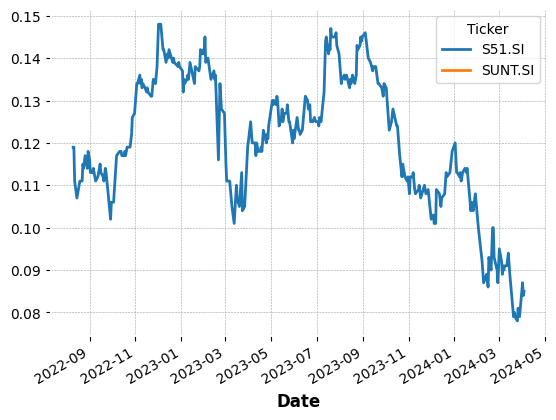

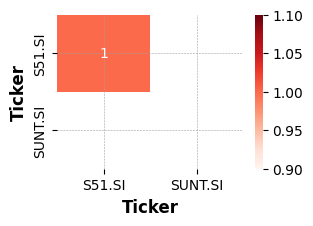

In [85]:
import seaborn as sns
historical_start_date = '2022-08-09'
# Define the ticker list
# Capitaland A17U, SUNT.SI cannot download
ticker_list = ['S51.SI']

# Fetch the data
data = yf.download(ticker_list, historical_start_date)['Adj Close'] # Auto adjust is false
data.index = pd.to_datetime(data.index)
display(data.tail(20))
data.plot()

plt.figure(figsize=(3,2))
sns.heatmap(data.corr(), cmap="Reds", annot=True)
plt.show()

In [ ]:
df


In [14]:
root_dir = path_yq.get_root_dir(cur_dir=cur_dir)
csv_path = Path.joinpath(root_dir, "data", f"{ticker}_{start_date}_{end_date}.csv")

# Get df
try:
    df.to_csv(csv_path)
except NameError:
    print(f"df not defined, trying to fetch from csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)

In [16]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(keys="Date", inplace=True)

mpf plot: https://github.com/matplotlib/mplfinance?tab=readme-ov-file

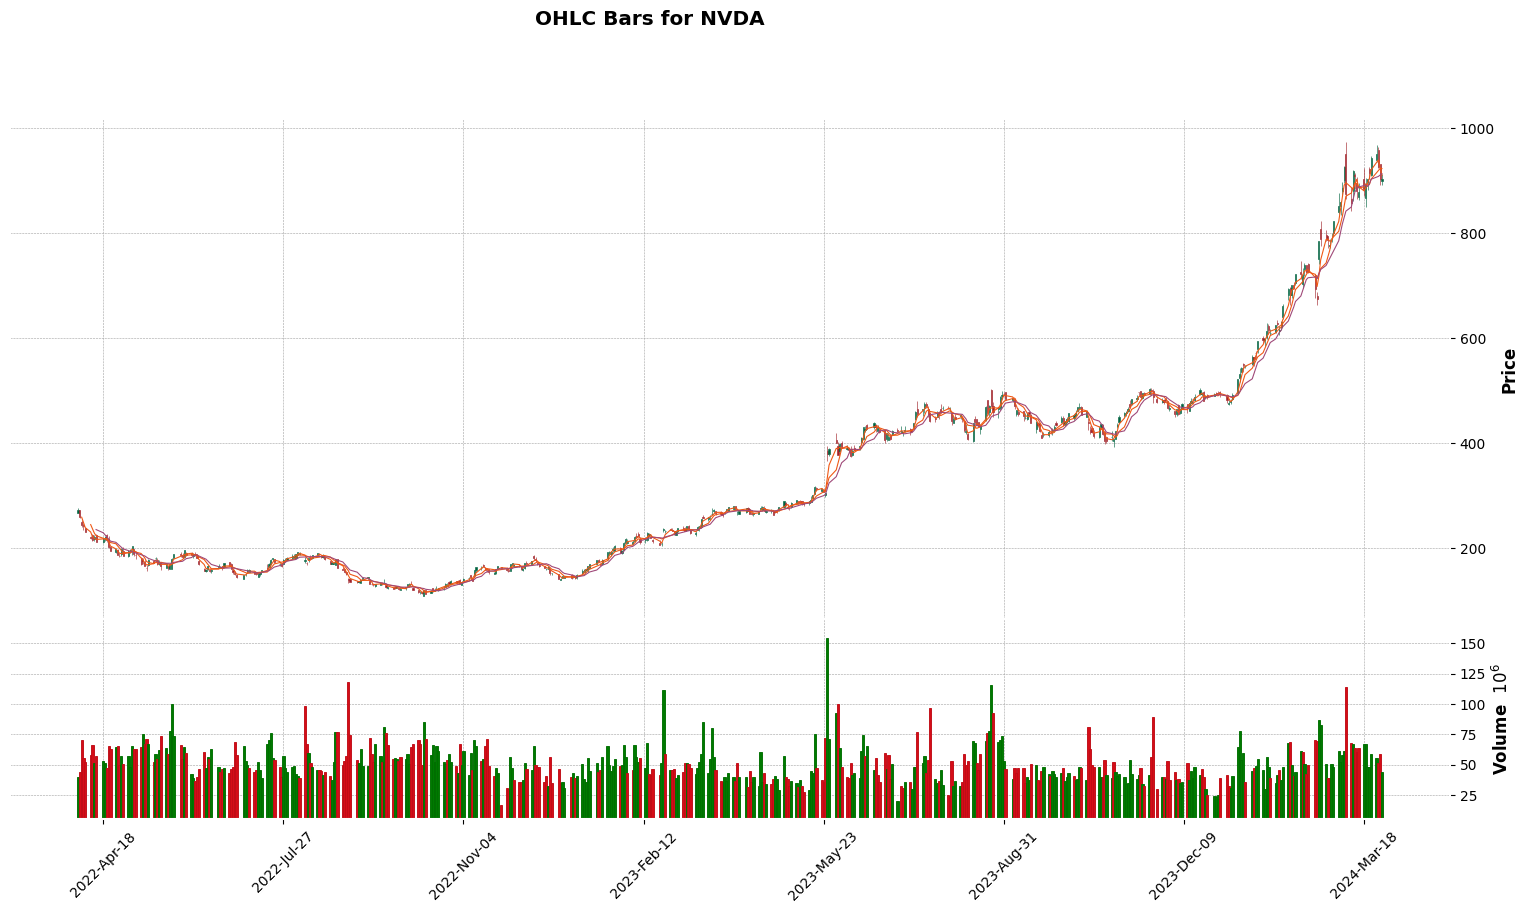

In [25]:
mpf.plot(df, type='candle', style='charles', figsize=(20, 10), title="OHLC Bars for NVDA", volume=True, show_nontrading=True, mav=(3, 6, 9))

In [27]:
df.isna().sum()


Open            0
High            0
Low             0
Close           0
Volume          0
VWAP            0
Transactions    0
dtype: int64

# Features
- Technical indicators
- Fundamental indicators
- Date features
- Holiday indicators etc.

# Preprocessing
- Train-test split
- Scale data (only fit-transform for train, but not for test)
- Decide which to predict. Have open and predict the close for the same day? Have the close for the previous day and predict next open?

In [49]:
def create_technical_indicators(tmp: pd.DataFrame):
    df = tmp.copy(deep=True)

    # Date features
    df['Year'], df['Month'], df['Day'] = df.index.year, df.index.month, df.index.day

    # Use the close price to create the indicators
    df['BB High'], df['BB Low']= ta.volatility.bollinger_hband(df['Close']), ta.volatility.bollinger_lband(df['Close'])

    
    
    # Takes the past 20 data, including the current one to calculate the mean
    df['MA_50'] = df['Close'].rolling(window=50).mean()

    df['MA_20'] = df['Close'].rolling(window=20).mean()

    df['MA_5'] = df['Close'].rolling(window=5).mean()

    df['Future Close'] = df['Close'].shift(-1)

    return df

In [50]:
df2 = create_technical_indicators(tmp=df)

In [51]:
df2

,Open,High,Low,Close,Volume,VWAP,Transactions,Year,Month,Day,BB High,BB Low,MA_50,MA_20,MA_5,Future Close
Date,,,,,,,,,,,,,,,,
2022-04-04,267.28,275.5800,266.1300,273.60,39770782.0,272.5287,499185,2022,4,4,NaN,NaN,NaN,NaN,NaN,259.31
2022-04-05,272.54,273.1900,258.2000,259.31,43654352.0,262.9166,639993,2022,4,5,NaN,NaN,NaN,NaN,NaN,244.07
2022-04-06,249.34,253.0000,240.0300,244.07,70076148.0,245.2649,988183,2022,4,6,NaN,NaN,NaN,NaN,NaN,242.08
2022-04-07,244.41,247.2200,234.7800,242.08,55799236.0,241.5490,714654,2022,4,7,NaN,NaN,NaN,NaN,NaN,231.19
2022-04-08,239.17,239.2300,230.6201,231.19,52478064.0,233.2497,671401,2022,4,8,NaN,NaN,NaN,NaN,250.050,219.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22,911.41,947.7799,908.3401,942.89,58641936.0,935.1787,1161163,2024,3,22,965.179031,770.070469,740.1117,867.62475,907.898,950.02
2024-03-25,939.41,967.6599,935.1000,950.02,55204733.0,954.4802,1113327,2024,3,25,972.764014,778.395486,748.1477,875.57975,920.992,925.61
2024-03-26,958.51,963.7500,925.0200,925.61,51164758.0,944.5258,984593,2024,3,26,972.977240,792.042260,755.7179,882.50975,927.318,902.50


In [52]:
df2.dropna(inplace=True)
df2

,Open,High,Low,Close,Volume,VWAP,Transactions,Year,Month,Day,BB High,BB Low,MA_50,MA_20,MA_5,Future Close
Date,,,,,,,,,,,,,,,,
2022-06-14,157.310,160.6600,154.1200,158.36,46953452.0,157.6400,479628,2022,6,14,199.181719,154.609281,193.1202,176.89550,170.306,165.27
2022-06-15,160.950,168.6800,159.2600,165.27,56393565.0,163.4682,560818,2022,6,15,198.791225,153.349775,190.9536,176.07050,166.064,156.01
2022-06-16,158.600,159.4232,154.0100,156.01,54484867.0,155.9775,568658,2022,6,16,199.608940,151.195060,188.8876,175.40200,161.170,158.80
2022-06-17,156.480,159.9500,153.2800,158.80,63033397.0,157.8160,496529,2022,6,17,200.000810,149.559190,187.1822,174.78000,158.982,165.66
2022-06-21,164.745,170.0800,164.0700,165.66,48307138.0,167.5516,518114,2022,6,21,200.022415,149.409585,185.6538,174.71600,160.820,163.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-21,923.000,926.4800,904.0500,914.35,47969971.0,916.4411,1005129,2024,3,21,956.878929,762.898571,732.1239,859.88875,894.993,942.89
2024-03-22,911.410,947.7799,908.3401,942.89,58641936.0,935.1787,1161163,2024,3,22,965.179031,770.070469,740.1117,867.62475,907.898,950.02
2024-03-25,939.410,967.6599,935.1000,950.02,55204733.0,954.4802,1113327,2024,3,25,972.764014,778.395486,748.1477,875.57975,920.992,925.61


## Split data

- Need to have train, val, test
- General requirements:
    - Ideally no NA values, otherwise model performance might be affected
    - Number of rows TBC, cannot be too little (not enough data to train), and cannot 
    be too much also (computationally expensive)
- Specific requirements:
    - df2 (not sure if need date as index yet)
    - Features (should be able to have both categorical and numerical)
    - Target variable: Future Close

In [68]:
# We still need the current Close to predict the next close
X = df2.drop(columns=['Future Close'])
y = df2['Future Close']

In [71]:
X

,Open,High,Low,Close,Volume,VWAP,Transactions,Year,Month,Day,BB High,BB Low,MA_50,MA_20,MA_5
Date,,,,,,,,,,,,,,,
2022-06-14,157.310,160.6600,154.1200,158.36,46953452.0,157.6400,479628,2022,6,14,199.181719,154.609281,193.1202,176.89550,170.306
2022-06-15,160.950,168.6800,159.2600,165.27,56393565.0,163.4682,560818,2022,6,15,198.791225,153.349775,190.9536,176.07050,166.064
2022-06-16,158.600,159.4232,154.0100,156.01,54484867.0,155.9775,568658,2022,6,16,199.608940,151.195060,188.8876,175.40200,161.170
2022-06-17,156.480,159.9500,153.2800,158.80,63033397.0,157.8160,496529,2022,6,17,200.000810,149.559190,187.1822,174.78000,158.982
2022-06-21,164.745,170.0800,164.0700,165.66,48307138.0,167.5516,518114,2022,6,21,200.022415,149.409585,185.6538,174.71600,160.820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-21,923.000,926.4800,904.0500,914.35,47969971.0,916.4411,1005129,2024,3,21,956.878929,762.898571,732.1239,859.88875,894.993
2024-03-22,911.410,947.7799,908.3401,942.89,58641936.0,935.1787,1161163,2024,3,22,965.179031,770.070469,740.1117,867.62475,907.898
2024-03-25,939.410,967.6599,935.1000,950.02,55204733.0,954.4802,1113327,2024,3,25,972.764014,778.395486,748.1477,875.57975,920.992


In [86]:
n_splits = 5
split_idx = int(len(df2) * 0.8)

# FIXME: Assess the model on different sets and use the best one
tscv = TimeSeriesSplit(n_splits=n_splits)

# TODO: Assess the models
# Now do CV for assessing robustness, but later on, the train and validation should
# Choose the best model/just go according to the sequential split
for train_idx, val_idx in tscv.split(X.iloc[:split_idx]):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Scale TODO: Make into a function
    scaler_choice = 'standard'
    if scaler_choice == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

X_test, y_test = X.iloc[split_idx:], y.iloc[split_idx:]



## Loading dataset

In [105]:
start_time = time.time()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time is {elapsed_time:3f}s.")

Elapsed time is 0.000021s.


In [116]:
mps_device = torch.device('mps')
print(type(mps_device))
batch_size = 64

def convert_numpy_torch(arr: np.ndarray) -> torch:
    if isinstance(arr, (pd.DataFrame, pd.Series)):
        arr = arr.to_numpy()
    if isinstance(arr, np.ndarray):
        # This does not make a copy, but any changes will affect the original arr
        # Alternative: torch.tensor(arr, dtype=torch.float32)
        return torch.from_numpy(arr).float().to(mps_device) # Ensure it is a float tensor, and move to device
    else:
        raise ValueError(f"The input\n{arr}\nis not an ndarray, it is a {type(arr)}.")

train_dataset = TensorDataset(convert_numpy_torch(X_train_scaled),
                              convert_numpy_torch(y_train))
val_dataset = TensorDataset(convert_numpy_torch(X_val_scaled),
                            convert_numpy_torch(y_val))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


<class 'torch.device'>


# Model

## Fitting

Afterwards for really testing against test

In [ ]:
#
# X_train, X_val, y_train, y_val = train_test_split(X.iloc[:split_idx], y.iloc[:split_idx], shuffle=False, test_size=0.2)